In [3]:
 #Import all required libraries
 import os
 import cv2
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 from sklearn.model_selection import train_test_split
 from sklearn.ensemble import RandomForestClassifier
 from sklearn.utils.class_weight import compute_class_weight
 from sklearn.metrics import classification_report, confusion_matrix
 import tensorflow as tf
 from tensorflow import keras
 from tensorflow.keras.applications import ResNet50
 from tensorflow.keras.applications.resnet50 import preprocess_input
 from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
 from tensorflow.keras.models import Model
 from tensorflow.keras.utils import to_categorical
 from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Download and Extract Dataset

In [4]:
import kagglehub
import zipfile

path = kagglehub.dataset_download("aryansinghal10/alzheimers-multiclass-dataset-equal-and-augmented")
print("Path to dataset files:", path)

# Extract zip files
for file in os.listdir(path):
  if file.endswith(".zip"):
    zip_path = os.path.join(path, file)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
       zip_ref.extractall(path)
       print(f"Unzipped: {file}")

# Set combined directory
combined_dir = os.path.join(path, "combined_images")
print(f"\nCombined directory: {combined_dir}")
print(f"Contents: {os.listdir(combined_dir)[:10]}")

Path to dataset files: /kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented

Combined directory: /kaggle/input/alzheimers-multiclass-dataset-equal-and-augmented/combined_images
Contents: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


In [5]:
categories = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

def create_dataset(data_dir):
   
    data = []
    labels = []

    print("Loading images from each class...")
    for category in categories:
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)
        image_count = 0

        for img in os.listdir(path):
            try:
                # Read image
                img_array = cv2.imread(os.path.join(path, img), 1)
                if img_array is None:
                    continue

                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                resized_array = cv2.resize(img_array, (128, 128))
                data.append(resized_array)
                labels.append(class_num)
                image_count += 1
            except Exception as e:
                print(f"Error loading {img}: {e}")
                pass
        print(f"  {category} (Class {class_num}): {image_count} images loaded")

    return np.array(data), np.array(labels)

# Load data
X, y = create_dataset(combined_dir)
print(f"\nTotal: Loaded {len(X)} images across 4 classes.")
print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Loading images from each class...
  ModerateDemented (Class 0): 10000 images loaded
  NonDemented (Class 1): 12800 images loaded
  VeryMildDemented (Class 2): 11200 images loaded
  MildDemented (Class 3): 10000 images loaded

Total: Loaded 44000 images across 4 classes.
Data shape: (44000, 128, 128, 3)
Labels shape: (44000,)


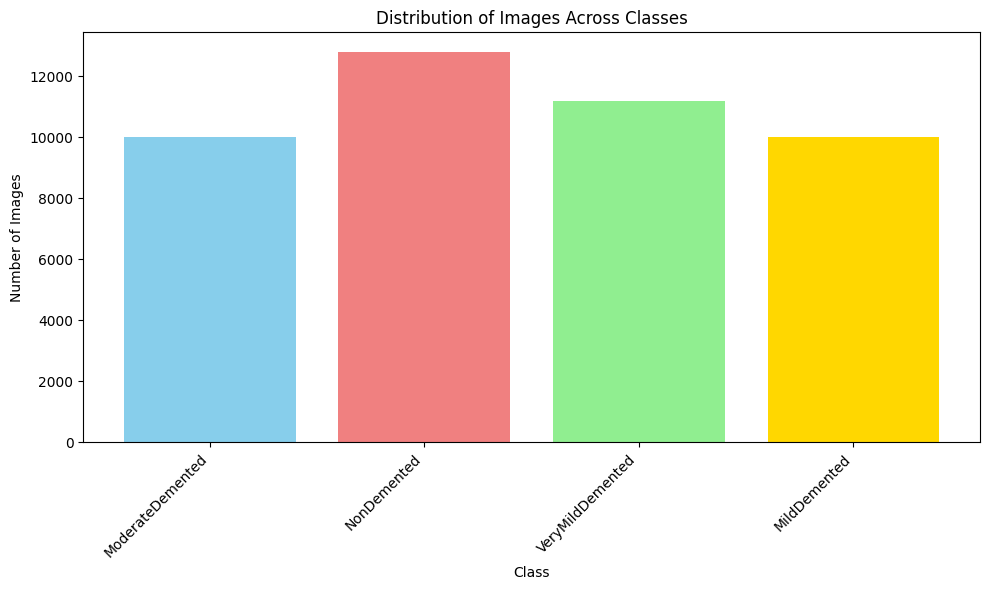

In [6]:
# Visualize class distribution
unique_labels, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(x=[categories[i] for i in unique_labels], height=counts, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Data Inspection

In [7]:
print("="*60)
print("SUMMARY STATISTICS FOR X (IMAGE DATA)")
print("="*60)
print(f"  Shape: {X.shape}")
print(f"  Data Type: {X.dtype}")
print(f"  Minimum pixel value: {np.min(X)}")
print(f"  Maximum pixel value: {np.max(X)}")
print(f"  Mean pixel value: {np.mean(X):.2f}")
print(f"  Standard deviation: {np.std(X):.2f}")
print("\n" + "="*60)
print("SUMMARY STATISTICS FOR y (LABELS)")
print("="*60)
unique_labels, counts = np.unique(y, return_counts=True)
label_distribution = pd.DataFrame({
    "Label": unique_labels,
    "Class Name": [categories[i] for i in unique_labels],
    "Count": counts,
    "Percentage": [f"{(c/len(y)*100):.2f}%" for c in counts]
})
display(label_distribution)
# Check for class imbalance
max_count = max(counts)
min_count = min(counts)
if max_count / min_count > 2:
    print(f"\n WARNING: Class imbalance detected (ratio: {max_count/min_count:.2f}:1)")
    print("   Recommendation: Use class weights during training")

SUMMARY STATISTICS FOR X (IMAGE DATA)
  Shape: (44000, 128, 128, 3)
  Data Type: uint8
  Minimum pixel value: 0
  Maximum pixel value: 255
  Mean pixel value: 74.53
  Standard deviation: 81.22

SUMMARY STATISTICS FOR y (LABELS)


,Label,Class Name,Count,Percentage
0,0,ModerateDemented,10000,22.73%
1,1,NonDemented,12800,29.09%
2,2,VeryMildDemented,11200,25.45%
3,3,MildDemented,10000,22.73%


## Visualization of Average Profiles###  (EDA)

Data Shape: (44000, 128, 128, 3)


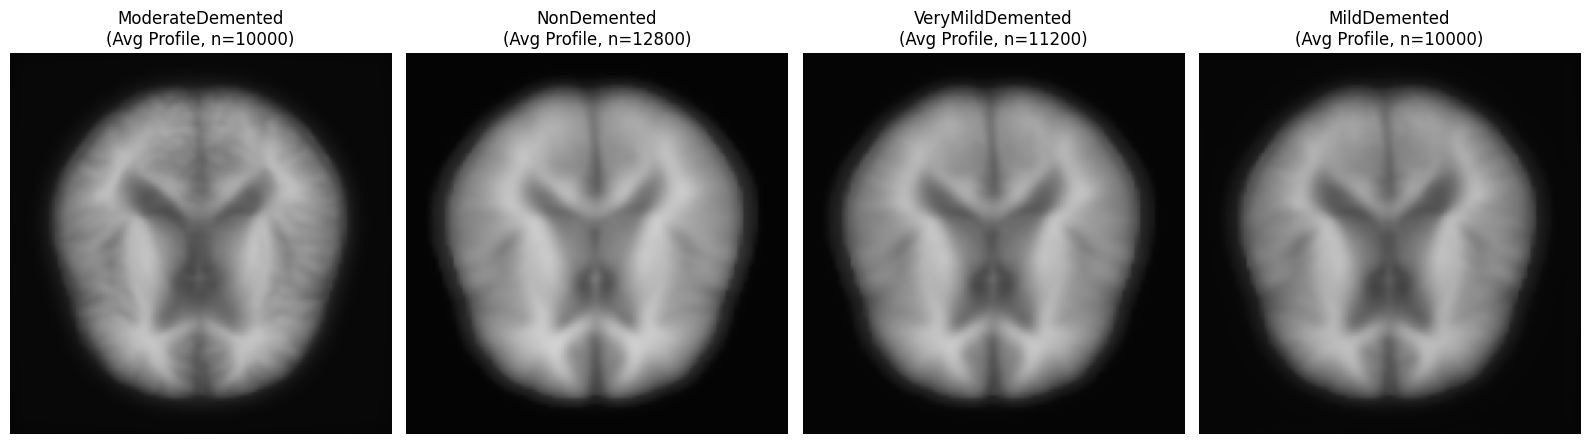

In [8]:
def plot_average_profiles(X, y, categories):
   """    Plot average image for each class
      """
   print(f"Data Shape: {X.shape}")
   plt.figure(figsize=(16, 6))
   for i in range(4):
     idx = np.where(y == i)[0]
     if len(idx) == 0:
       print(f"No images for {categories[i]}")
       continue
     mean_img = np.mean(X[idx], axis=0)
     mean_img_normalized = mean_img / 255.0
     plt.subplot(1, 4, i+1)
     plt.imshow(mean_img_normalized)
     plt.title(f"{categories[i]}\n(Avg Profile, n={len(idx)})")
     plt.axis('off')
   plt.tight_layout()
   plt.show()
plot_average_profiles(X, y, categories)

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2, random_state=42):
    X = np.array(X)
    y = np.array(y)

    indices = np.arange(len(X))
    np.random.seed(random_state)
    np.random.shuffle(indices)

    X_shuffled = X[indices]
    y_shuffled = y[indices]

    X_train, X_test, y_train, y_test = train_test_split(
        X_shuffled,
        y_shuffled,
        test_size=test_size,
        stratify=y_shuffled,
        random_state=random_state
    )

    return X_train, X_test, y_train, y_test


In [10]:
X_train, X_test, y_train, y_test = split_data(X, y)

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train, return_counts=True))


(35200, 128, 128, 3)
(8800, 128, 128, 3)
(array([0, 1, 2, 3]), array([ 8000, 10240,  8960,  8000]))


##  Feature Extraction with ResNet50 (For Analysis)This step extracts features for feature importance analysis. The actual model will use end-to-end training.

In [11]:
def extract_features_resnet(X_train, X_test):
    """
    Extract features using ResNet50
    Proper preprocessing for ResNet50
    """
    print("\n" + "="*60)
    print("FEATURE EXTRACTION WITH RESNET50")
    print("="*60)

   
    X_train_processed = preprocess_input(X_train.astype('float32'))
    X_test_processed = preprocess_input(X_test.astype('float32'))

    # Load ResNet50 without top layers
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(128, 128, 3),
        pooling='avg'
    )

    print("Extracting features from training set...")
    X_train_features = base_model.predict(X_train_processed, batch_size=32, verbose=1)

    print("Extracting features from testing set...")
    X_test_features = base_model.predict(X_test_processed, batch_size=32, verbose=1)

    print(f"\nFeature extraction complete!")
    print(f"  Original shape: {X_train.shape}")
    print(f"  Feature shape: {X_train_features.shape}")

    return X_train_features, X_test_features, base_model
    print("Before feature extraction")
extract_features_resnet(X_train, X_test)
print("After feature extraction")



FEATURE EXTRACTION WITH RESNET50


I0000 00:00:1769105593.279550      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Extracting features from training set...


I0000 00:00:1769105615.544980     131 service.cc:152] XLA service 0x7973e4005640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769105615.545020     131 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769105616.349544     131 cuda_dnn.cc:529] Loaded cuDNN version 91002


   6/1100 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step

I0000 00:00:1769105618.944370     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step
Extracting features from testing set...
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

Feature extraction complete!
  Original shape: (35200, 128, 128, 3)
  Feature shape: (35200, 2048)
After feature extraction


## Feature Importance Analysis

In [12]:
def plot_feature_importance(X_features, y, top_n=10):
    """
    Analyze feature importance using Random Forest
    """
    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    # Train Random Forest for feature selection
    selector = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    selector.fit(X_features, y)

    # Get feature importances
    importances = selector.feature_importances_
    indices = np.argsort(importances)[-top_n:]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(top_n), importances[indices], color='darkred')
    plt.yticks(range(top_n), [f"Feature_{i}" for i in indices])
    plt.xlabel('Importance Score')
    plt.title(f"Top {top_n} Engineered Predictors of Alzheimer's Stage")
    plt.tight_layout()
    plt.show()

    print(f"Random Forest Accuracy on features: {selector.score(X_features, y):.2f}")

In [13]:
X_train_features, X_test_features, base_model = extract_features_resnet(
    X_train, X_test
)



FEATURE EXTRACTION WITH RESNET50
Extracting features from training set...
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step
Extracting features from testing set...
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step

Feature extraction complete!
  Original shape: (35200, 128, 128, 3)
  Feature shape: (35200, 2048)


Before plotting

FEATURE IMPORTANCE ANALYSIS


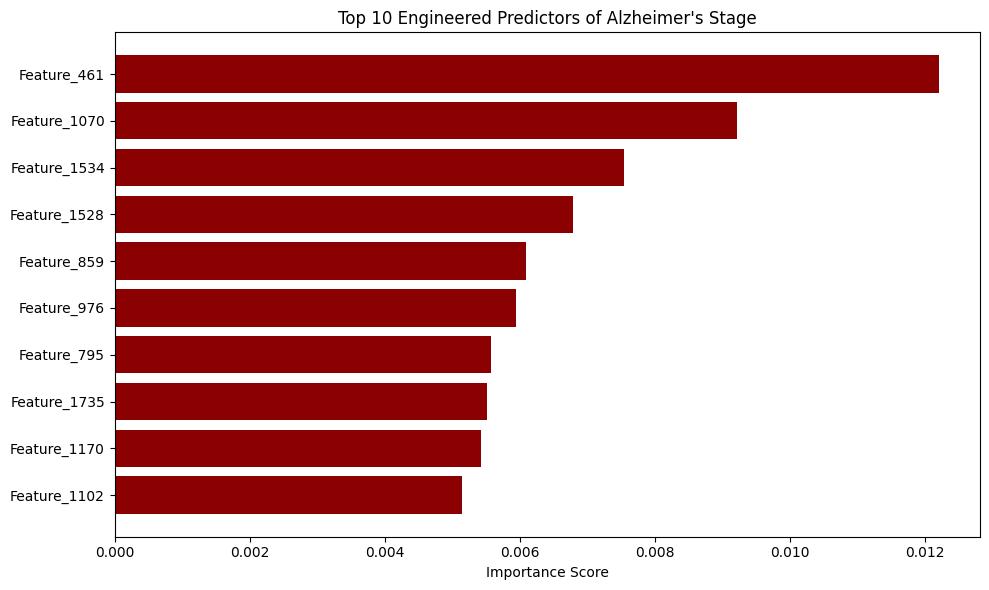

Random Forest Accuracy on features: 0.89
After plotting


In [14]:
print("Before plotting")
plot_feature_importance(X_train_features, y_train)
print("After plotting")


## Build the  Model 

In [15]:
def build_alzheimers_model(input_shape=(128, 128, 3), num_classes=4):
    """
    Build complete model with ResNet50 backbone
    
    """
    print("\n" + "="*60)
    print("BUILDING MODEL")
    print("="*60)

    # Load ResNet50 base
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    # CRITICAL FIX: Freeze base model layers initially
    # This prevents destroying pre-trained weights
    base_model.trainable = False

    # Build classifier head
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Add custom classification head
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)

    # CRITICAL FIX 5: Use softmax for multi-class classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    print(f"Model built successfully!")
    print(f"  Total parameters: {model.count_params():,}")
    print(f"  Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

    return model


In [16]:
model = build_alzheimers_model()
model.summary()



BUILDING MODEL
Model built successfully!
  Total parameters: 24,779,396
  Trainable parameters: 1,186,564


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,779,396 (94.53 MB)

 Trainable params: 1,186,564 (4.53 MB)

 Non-trainable params: 23,592,832 (90.00 MB)

In [17]:
def compile_model(model, learning_rate=0.001):
    """
    Compile model with proper loss and metrics
   Use categorical_crossentropy for multi-class
    """
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',  
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc', multi_label=False)
        ]
    )

    print("\nModel compiled with:")
    print(f"  Optimizer: Adam (lr={learning_rate})")
    print(f"  Loss: categorical_crossentropy")
    print(f"  Metrics: accuracy, precision, recall, auc")

    return model

In [18]:
model = compile_model(model, learning_rate=0.001)



Model compiled with:
  Optimizer: Adam (lr=0.001)
  Loss: categorical_crossentropy
  Metrics: accuracy, precision, recall, auc


In [19]:
def prepare_training_data(X_train, X_test, y_train, y_test, num_classes=4):
    """
    Prepare data for training
     Proper normalization and encoding
    """
    print("\n" + "="*60)
    print("PREPARING DATA FOR TRAINING")
    print("="*60)

    
    X_train_rgb = X_train.astype('float32')
    X_test_rgb = X_test.astype('float32')

    # One-hot encode labels
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    print(f"Training samples: {len(X_train_rgb)}")
    print(f"Testing samples: {len(X_test_rgb)}")
    print(f"Input shape: {X_train_rgb.shape[1:]}")
    print(f"Label shape: {y_train_cat.shape[1:]}")

    # Verifying one-hot encoding
    print("\nLabel encoding verification:")
    for i in range(min(3, len(y_train))):
        print(f"  Original label: {y_train[i]} → One-hot: {y_train_cat[i]}")

    return X_train_rgb, X_test_rgb, y_train_cat, y_test_cat


In [20]:
from tensorflow.keras.utils import to_categorical

X_train_rgb, X_test_rgb, y_train_cat, y_test_cat = prepare_training_data(
    X_train, X_test, y_train, y_test, num_classes=4
)



PREPARING DATA FOR TRAINING
Training samples: 35200
Testing samples: 8800
Input shape: (128, 128, 3)
Label shape: (4,)

Label encoding verification:
  Original label: 3 → One-hot: [0. 0. 0. 1.]
  Original label: 1 → One-hot: [0. 1. 0. 0.]
  Original label: 3 → One-hot: [0. 0. 0. 1.]


##  Compute Class Weights to handle Class Imbalance

In [21]:
def compute_class_weights(y_train, categories):
    """
    Compute class weights to handle imbalance
    """
    print("\n" + "="*60)
    print("COMPUTING CLASS WEIGHTS")
    print("="*60)

    # Compute class weights
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weights = dict(enumerate(class_weights_array))

    print("Class weights:")
    for class_idx, weight in class_weights.items():
        print(f"  Class {class_idx} ({categories[class_idx]}): {weight:.4f}")

    return class_weights

In [22]:
categories = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']


class_weights = compute_class_weights(y_train, categories)



COMPUTING CLASS WEIGHTS
Class weights:
  Class 0 (ModerateDemented): 1.1000
  Class 1 (NonDemented): 0.8594
  Class 2 (VeryMildDemented): 0.9821
  Class 3 (MildDemented): 1.1000


In [23]:
print("Unique labels in y_train:", np.unique(y_train))


Unique labels in y_train: [0 1 2 3]


In [24]:
def train_model(model, X_train, y_train, X_test, y_test,
                class_weights=None, epochs=50, batch_size=32):
   
   
    print("\n" + "="*60)
    print("TRAINING MODEL")
    print("="*60)

    
    X_train_processed = preprocess_input(X_train)
    X_test_processed = preprocess_input(X_test)

    # Define callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_alzheimers_model.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    print(f"\nStarting training for {epochs} epochs...")
    print(f"  Batch size: {batch_size}")
    print(f"  Class weights: {'Yes' if class_weights else 'No'}")

    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_test_processed, y_test),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    print("\nTraining complete!")
    return history, X_train_processed, X_test_processed

In [25]:
# Prepared training data
X_train_rgb, X_test_rgb, y_train_cat, y_test_cat = prepare_training_data(
    X_train, X_test, y_train, y_test, num_classes=4
)

# Compiled model
model = build_alzheimers_model()
model = compile_model(model)

# Computed class weights
categories = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']
class_weights = compute_class_weights(y_train, categories)



PREPARING DATA FOR TRAINING
Training samples: 35200
Testing samples: 8800
Input shape: (128, 128, 3)
Label shape: (4,)

Label encoding verification:
  Original label: 3 → One-hot: [0. 0. 0. 1.]
  Original label: 1 → One-hot: [0. 1. 0. 0.]
  Original label: 3 → One-hot: [0. 0. 0. 1.]

BUILDING MODEL
Model built successfully!
  Total parameters: 24,779,396
  Trainable parameters: 1,186,564

Model compiled with:
  Optimizer: Adam (lr=0.001)
  Loss: categorical_crossentropy
  Metrics: accuracy, precision, recall, auc

COMPUTING CLASS WEIGHTS
Class weights:
  Class 0 (ModerateDemented): 1.1000
  Class 1 (NonDemented): 0.8594
  Class 2 (VeryMildDemented): 0.9821
  Class 3 (MildDemented): 1.1000


## Model 1

In [26]:
history, X_train_processed, X_test_processed = train_model(
    model,
    X_train_rgb,
    y_train_cat,
    X_test_rgb,
    y_test_cat,
    class_weights=class_weights,
    epochs=10,
    batch_size=32
)



TRAINING MODEL

Starting training for 10 epochs...
  Batch size: 32
  Class weights: Yes
Epoch 1/10
1098/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5538 - auc: 0.8124 - loss: 5.3928 - precision: 0.6232 - recall: 0.4467
Epoch 1: val_accuracy improved from -inf to 0.61886, saving model to best_alzheimers_model.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.5539 - auc: 0.8125 - loss: 5.3860 - precision: 0.6233 - recall: 0.4467 - val_accuracy: 0.6189 - val_auc: 0.8699 - val_loss: 1.3610 - val_precision: 0.7317 - val_recall: 0.4741 - learning_rate: 0.0010
Epoch 2/10
1098/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6110 - auc: 0.8643 - loss: 1.3629 - precision: 0.7259 - recall: 0.4624
Epoch 2: val_accuracy improved from 0.61886 to 0.63750, saving model to best_alzheimers_model.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.6110 - auc: 0.8643 - loss: 1.3629 - precision: 0.7259 - recall: 0.4624 - val_accuracy: 0.6375 - val_auc: 0.8882 - v

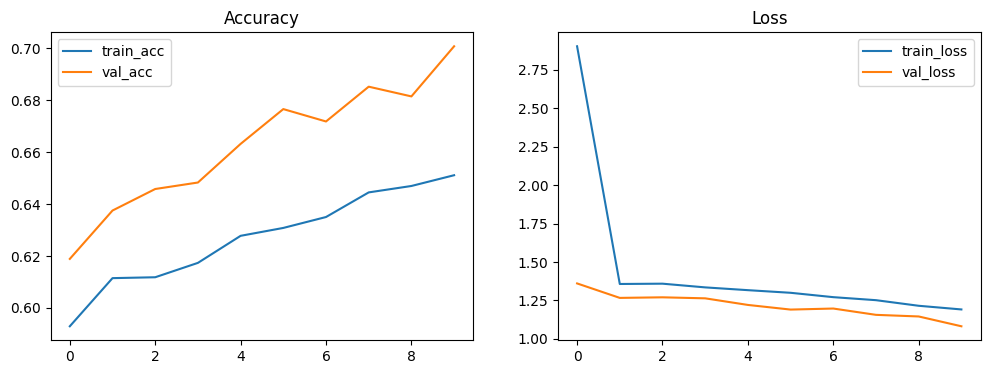

In [27]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


## Model 2

In [28]:
def build_alzheimers_model2(input_shape=(128,128,3), num_classes=4, unfreeze_top=20):
    """
    Build Model 2: fine-tuning top layers of ResNet50
    """
    from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
    from tensorflow.keras.models import Model
    from tensorflow.keras.applications import ResNet50
    import tensorflow as tf

    # Load base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape, pooling='avg')

    # Freeze all layers first
    base_model.trainable = False

    # Unfreeze top `unfreeze_top` layers for fine-tuning
    for layer in base_model.layers[-unfreeze_top:]:
        layer.trainable = True

    # Build classifier head
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    print(f"Model 2 built! Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
    return model


In [29]:
model2 = build_alzheimers_model2()
model2 = compile_model(model2, learning_rate=1e-4)  # lower LR for fine-tuning


Model 2 built! Trainable params: 9,068,804

Model compiled with:
  Optimizer: Adam (lr=0.0001)
  Loss: categorical_crossentropy
  Metrics: accuracy, precision, recall, auc


In [30]:
history2, X_train_processed, X_test_processed = train_model(
    model2,
    X_train_rgb, y_train_cat,
    X_test_rgb, y_test_cat,
    class_weights=class_weights,
    epochs=20,
    batch_size=32
)



TRAINING MODEL

Starting training for 20 epochs...
  Batch size: 32
  Class weights: Yes
Epoch 1/20
1099/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5413 - auc: 0.7933 - loss: 11.2853 - precision: 0.5933 - recall: 0.4607
Epoch 1: val_accuracy improved from -inf to 0.80307, saving model to best_alzheimers_model.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - accuracy: 0.5415 - auc: 0.7934 - loss: 11.2821 - precision: 0.5935 - recall: 0.4609 - val_accuracy: 0.8031 - val_auc: 0.9605 - val_loss: 6.3882 - val_precision: 0.8431 - val_recall: 0.7539 - learning_rate: 1.0000e-04
Epoch 2/20
1099/1100 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8066 - auc: 0.9599 - loss: 5.2827 - precision: 0.8362 - recall: 0.7760
Epoch 2: val_accuracy improved from 0.80307 to 0.87955, saving model to best_alzheimers_model.keras
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.8067 - auc: 0.9599 - loss: 5.2809 - precision: 0.8363 - recall: 0.7761 - val_accuracy: 0.8795 - val_auc: 0.98

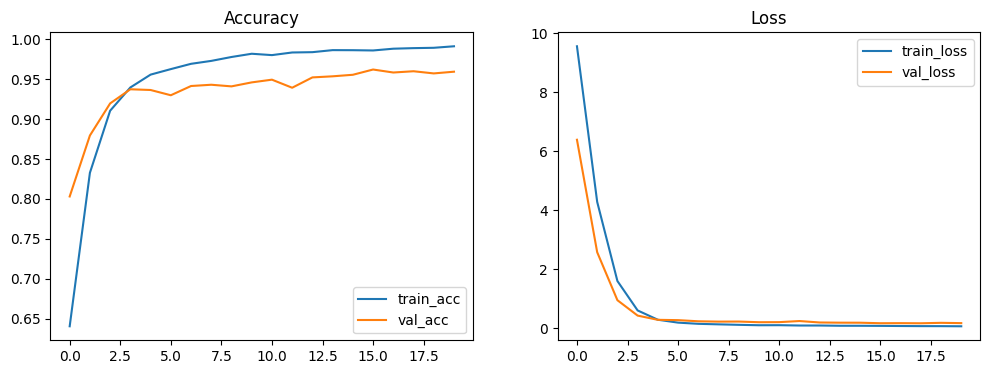

In [31]:
# Plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='train_acc')
plt.plot(history2.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='train_loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
# Save the model
model2.save("alzheimers_model2.keras")
print("Model saved as alzheimers_model2.keras")


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import math

def predict_and_visualize_from_paths(model, image_paths, categories, target_size=(128,128), images_per_row=5):
    """
    Predict classes from image file paths and visualize with proper spacing.
    
    Parameters:
    - model: Trained Keras model
    - image_paths: List of image file paths
    - categories: List of class names
    - target_size: Resize images
    - images_per_row: How many images per row in the plot
    """
    images = []
    valid_paths = []

    # Load images
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Could not read image {path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        images.append(img)
        valid_paths.append(path)

    if len(images) == 0:
        print("No valid images to predict.")
        return

    images = np.array(images, dtype='float32')
    X_processed = preprocess_input(images)
    preds = model.predict(X_processed)
    pred_classes = np.argmax(preds, axis=1)

    # Calculate rows needed
    n_images = len(images)
    n_rows = math.ceil(n_images / images_per_row)
    
    plt.figure(figsize=(4*images_per_row, 4*n_rows))
    
    for i, img in enumerate(images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.imshow(img.astype('uint8'))
        plt.axis('off')
        plt.title(f"Pred: {categories[pred_classes[i]]}\n({preds[i][pred_classes[i]]:.2f})", fontsize=10)
    
    plt.tight_layout(pad=2.0)  # adds padding between images
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


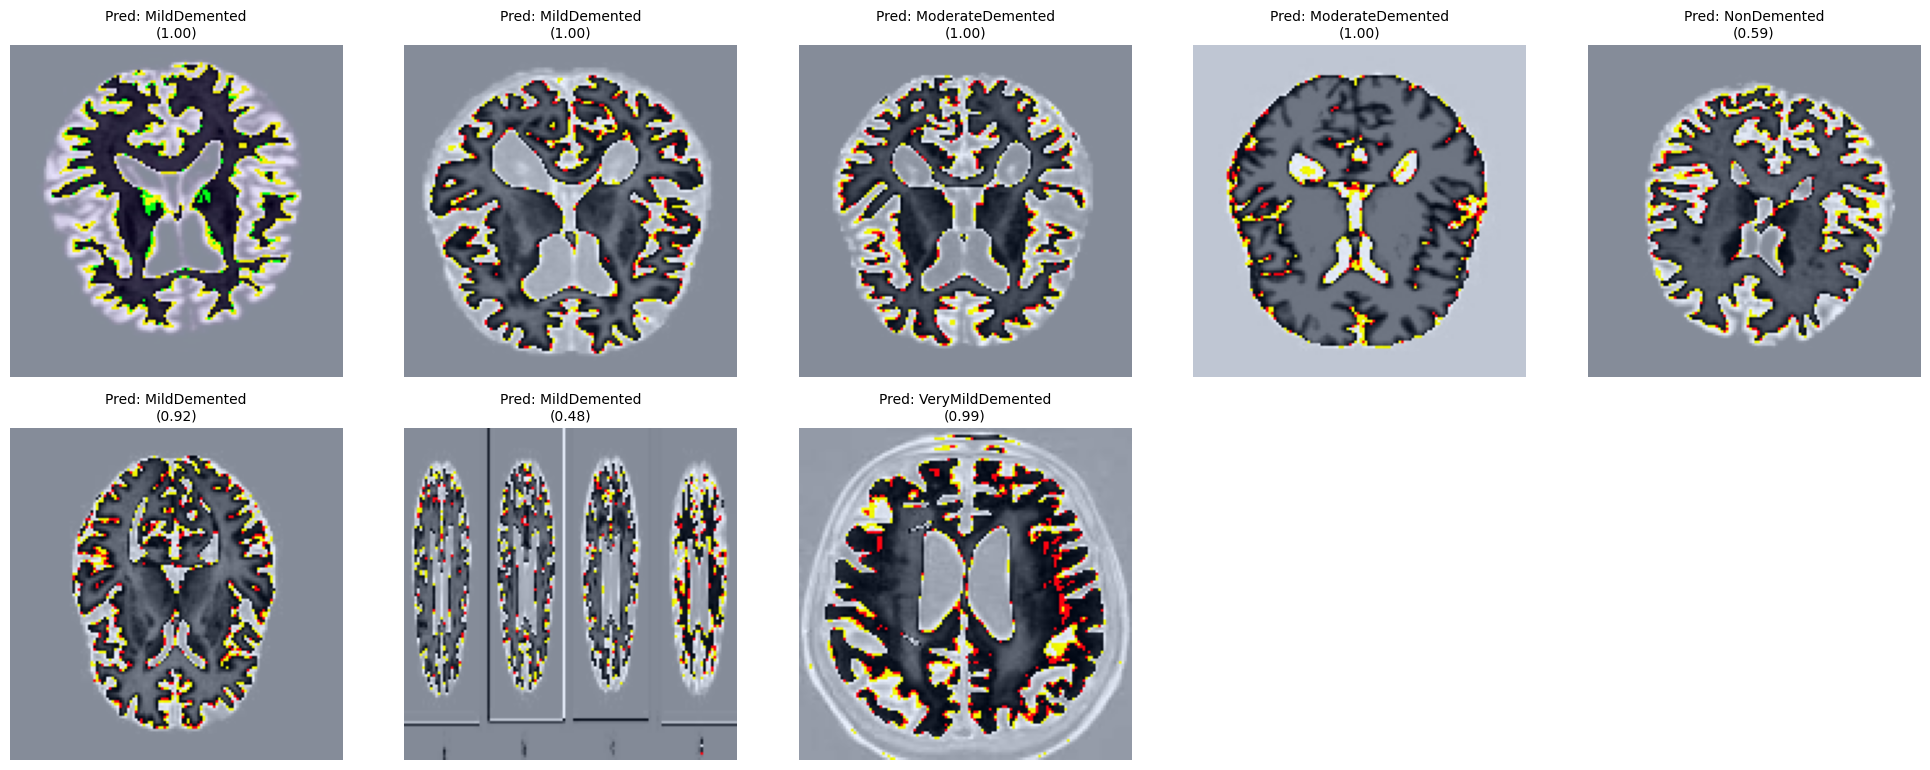

In [41]:
categories = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

predict_and_visualize_from_paths(model2, image_paths, categories)


image_paths = [
   '/kaggle/input/testing-mri/milddemented.jpg',
    '/kaggle/input/testing-mri/milddemented2.jpg',
    '/kaggle/input/testing-mri/moderatedemented1.jpg',
    '/kaggle/input/testing-mri/moderatedemented2.jpg',
    '/kaggle/input/testing-mri/nondemented1.jpg',
    '/kaggle/input/testing-mri/nondemented2.jpg',
    '/kaggle/input/testing-mri/verydemented1.jpg',
    '/kaggle/input/testing-mri/verydemented2.jpg'
  
]




In [36]:
# Save the model2
model2.save("alzheimers_model2.keras")
print("Model saved as alzheimers_model2.keras")


Model saved as alzheimers_model2.keras


In [37]:
# Save the model1
model.save("alzheimers_model1.keras")
print("Model saved as alzheimers_model1.keras")


Model saved as alzheimers_model1.keras
